#Лабораторная работа 3

##Оценка датасета

Для выполнения данного задания сначала оценим, насколько набор
данных, выбранный нами ранее, подходит для решения задачи.

Датасет можно найти по ссылке https://www.kaggle.com/datasets/taweilo/taiwan-wright-and-weight-sampling-data. Сами данные были взяты из выборочной статистики Министерства здравоохранения и социального обеспечения Тайваня.

Атрибуты:
* yr - возраст индивидуума - Integer (числовой тип)
* height - рост человека в сантиметрах - Float (числовой тип)
* weight - вес человека в килограммах - Float (числовой тип)
* bmi - индекс массы тела (ИМТ) - Float (числовой тип)
* gender - категориальное гендерное значение (0: женский, 1: мужской) - Integer (числовой тип)



В качестве метки возьмем gender. Мы хотим предсказывать пол человека (0 или 1) на основе других атрибутов, таких как рост, вес и ИМТ.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn

In [2]:
data = pd.read_csv("/content/2017_2020_bmi.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7770 entries, 0 to 7769
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      7770 non-null   object 
 1   height  7770 non-null   float64
 2   weight  7770 non-null   float64
 3   bmi     7770 non-null   float64
 4   gender  7770 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 303.6+ KB


Мы видим, что атрибут yr имеет тип данных object, поэтому мы не будем использовать yr в анализе.

Теперь удалим записи с пустыми полями:

In [3]:
data = data.dropna()

Посмотрим сколько уникальных меток существует в датасете:

In [4]:
data['gender'].value_counts(normalize=True)

,proportion
gender,
0,0.500772
1,0.499228


Классы сбалансированы.

##Классификация

Оценим и сравним результаты классификации, используя следующие
алгоритмы классификации:
* kNN
* дерево решений

Отбираем атрибуты со статистикой:

In [5]:
st_col = [column for column in data if column != 'gender' and column != 'yr']

X = data[st_col]
Y = data['gender']

Стандартизуем статистические данные:

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

Разделим на обучающую и тестовую выборку:

In [7]:
from sklearn.model_selection import train_test_split

X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, stratify=Y)

###kNN

Найдем оптимальный параметр k для kNN при помощи GridSearch:

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

grid_params = {'n_neighbors': [i for i in range(1, 30+1)],
               'weights': ['uniform', 'distance'],
               'metric': ['minkowski', 'euclidean', 'manhattan']
              }

gs = GridSearchCV(knn, grid_params, scoring='accuracy', refit=True)

g_res = gs.fit(X_tr, Y_tr)

k = g_res.best_params_['n_neighbors']
metric = g_res.best_params_['metric']
weights = g_res.best_params_['weights']

g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}

Здесь мы используем GridSearchCV для автоматического подбора гиперпараметров алгоритма kNN. В данном коде подбираются три ключевых параметра:
1. n_neighbors: Количество ближайших соседей, которых учитывать для классификации.
2. weights: Тип весов:
* 'uniform' — все соседи имеют одинаковое влияние.
* 'distance' — соседи, которые ближе, имеют больший вес.
3. metric: Метрика для расчета расстояния:
* 'minkowski' (по умолчанию для kNN, объединяет Евклидово и Манхэттенское расстояния, управляется параметром p).
* 'euclidean' (Евклидово расстояние).
* 'manhattan' (Манхэттенское расстояние).

Мы получили лучшие параметры для kNN. Теперь проведем kNN-классификацию:

In [26]:
knn = KNeighborsClassifier(n_neighbors=k, weights=weights).fit(X_tr, Y_tr)
predicted = knn.predict(X_t)

Оценим качество с помощью различных метрик:

* Accuracy
* Presicion, Recall, F-measure
* ROC

Accuary:

In [27]:
right = 0
wrong = 0

for i, gen in enumerate(Y_t):
    if predicted[i] == gen:
        right += 1
    else:
        wrong += 1

accuracy = right / (right + wrong)
print(accuracy)

0.9562532166752444


Presicion, Recall, F-measure:

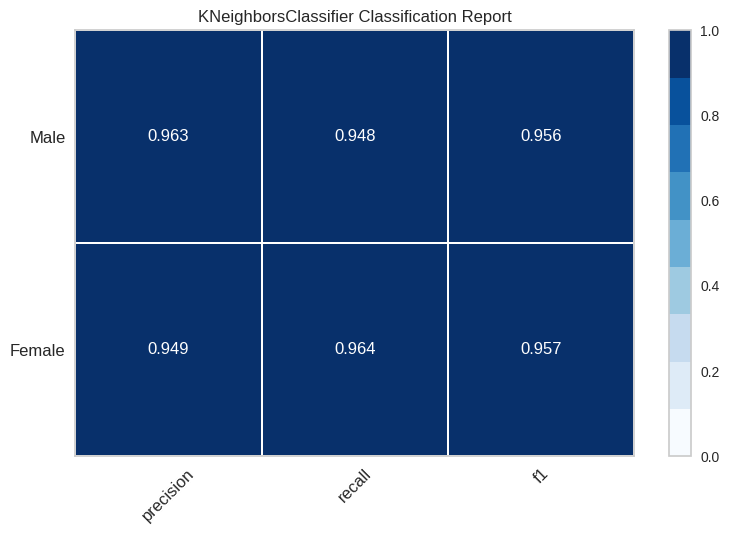

In [28]:
from yellowbrick.classifier import ClassificationReport

report = ClassificationReport(knn, classes=['Female', 'Male'], cmap="Blues")
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

ROC:

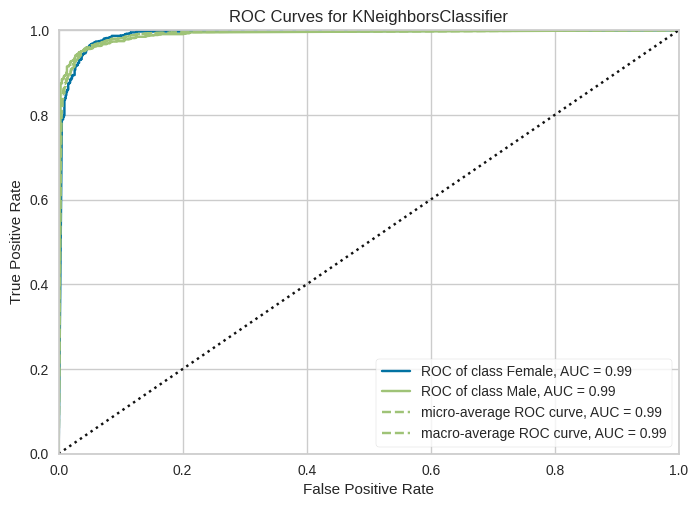

In [29]:
from yellowbrick.classifier import ROCAUC

report = ROCAUC(knn, classes=['Female', 'Male'])
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

###Дерево решений

In [30]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_tr, Y_tr)

predicted = dtc.predict(X_t)

Accuracy:

In [32]:
right = 0
wrong = 0

for i, gen in enumerate(Y_t):
    if predicted[i] == gen:
        right += 1
    else:
        wrong += 1

accuracy = right / (right + wrong)
print(accuracy)

0.9475038600102934


Presicion, Recall, F-measure:

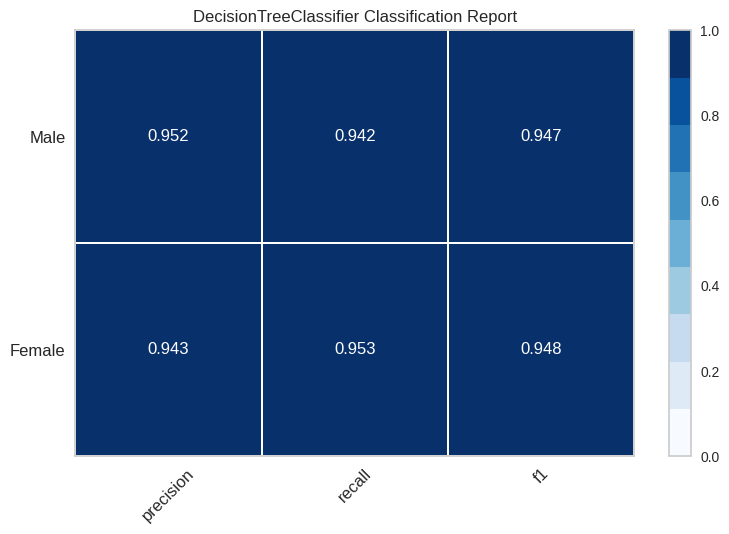

In [33]:
report = ClassificationReport(dtc, classes=['Female', 'Male'], cmap="Blues")
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

ROC:

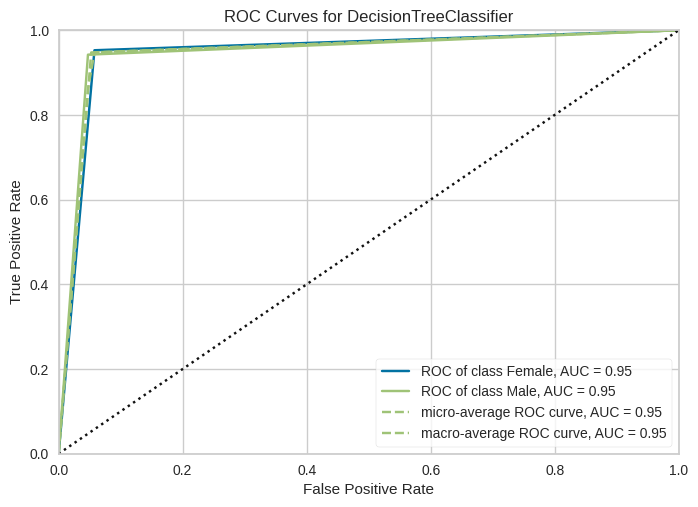

In [34]:
report = ROCAUC(dtc, classes=['Female', 'Male'])
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

###Проанализируем полученные результаты

В результате проделанной работы мы видим, что оба алгоритма классификации (kNN и дерево решений) показывают высокую точность, что указывает на хорошую способность предсказывать пол на основе данных о росте, весе и ИМТ. Алгоритм kNN оказался чуть более точным по сравнению с деревом решений, о чем говорит точность 95,62% и 94,75% соответственно, а также метрики Presicion, Recall, F-measure
и ROC, которые сильно похожи у обоих алгоритмов.
Модель отлично распознает и женщин, и мужчин, потому что в нашем случае сильная корреляция между атрибутами и полом. Атрибуты, такие как рост, вес и ИМТ, имеют значительные отличия между мужчинами и женщинами. Например, мужчины в среднем выше и тяжелее женщин, что делает эти признаки яркими маркерами для различения полов.
Индекс массы тела, хотя и зависит от роста и веса, может косвенно дополнительно уточнять различия между полами.
Эти различия создают четкие границы между классами "мужчины" и "женщины", что упрощает задачу классификации.